### Installation des dependances

```python
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install -q git+https://github.com/camenduru/textgen.git
!pip install -q accelerate
!pip install -q gradio
```

### Configuration du notebook

Ce notebook a été conçu pour fonctionner avec les fichiers de données fournis dans le cadre du projet de Data Science de l'ESME Sudria. Assurez-vous que les fichiers suivants se trouvent dans le même répertoire que ce notebook :

- `data.csv` : le fichier de données principal
- `config.py` : le fichier de configuration contenant les paramètres du projet

Avant de commencer l'analyse des données, exécutez la cellule suivante pour importer les bibliothèques nécessaires et charger les données.

In [ ]:
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from PIL import Image

[2024-03-29 09:08:23,795] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [ ]:
disable_torch_init()
MODEL = "4bit/llava-v1.5-13b-3GB"
model_name = get_model_name_from_path(MODEL)

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
CONV_MODE = "llava_v0"
def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

def process_image(image):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

def create_prompt(new_system: str = None, prompt: str = "",   CONV_MODE: str = "default"):
    conv = conv_templates[CONV_MODE].copy()
    if new_system is not None:
        conv.system = new_system
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN+ "\n" + prompt
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

def ask_image(image: Image, pre_prompt: str, prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt( pre_prompt,prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=2048,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()

def ask_text(prompt: str):
    prompt, conv = create_prompt( "",prompt)

    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=1024,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )

    return tokenizer.decode(
        output_ids[0, input_ids.shape[-1]:], skip_special_tokens=True
    ).strip()



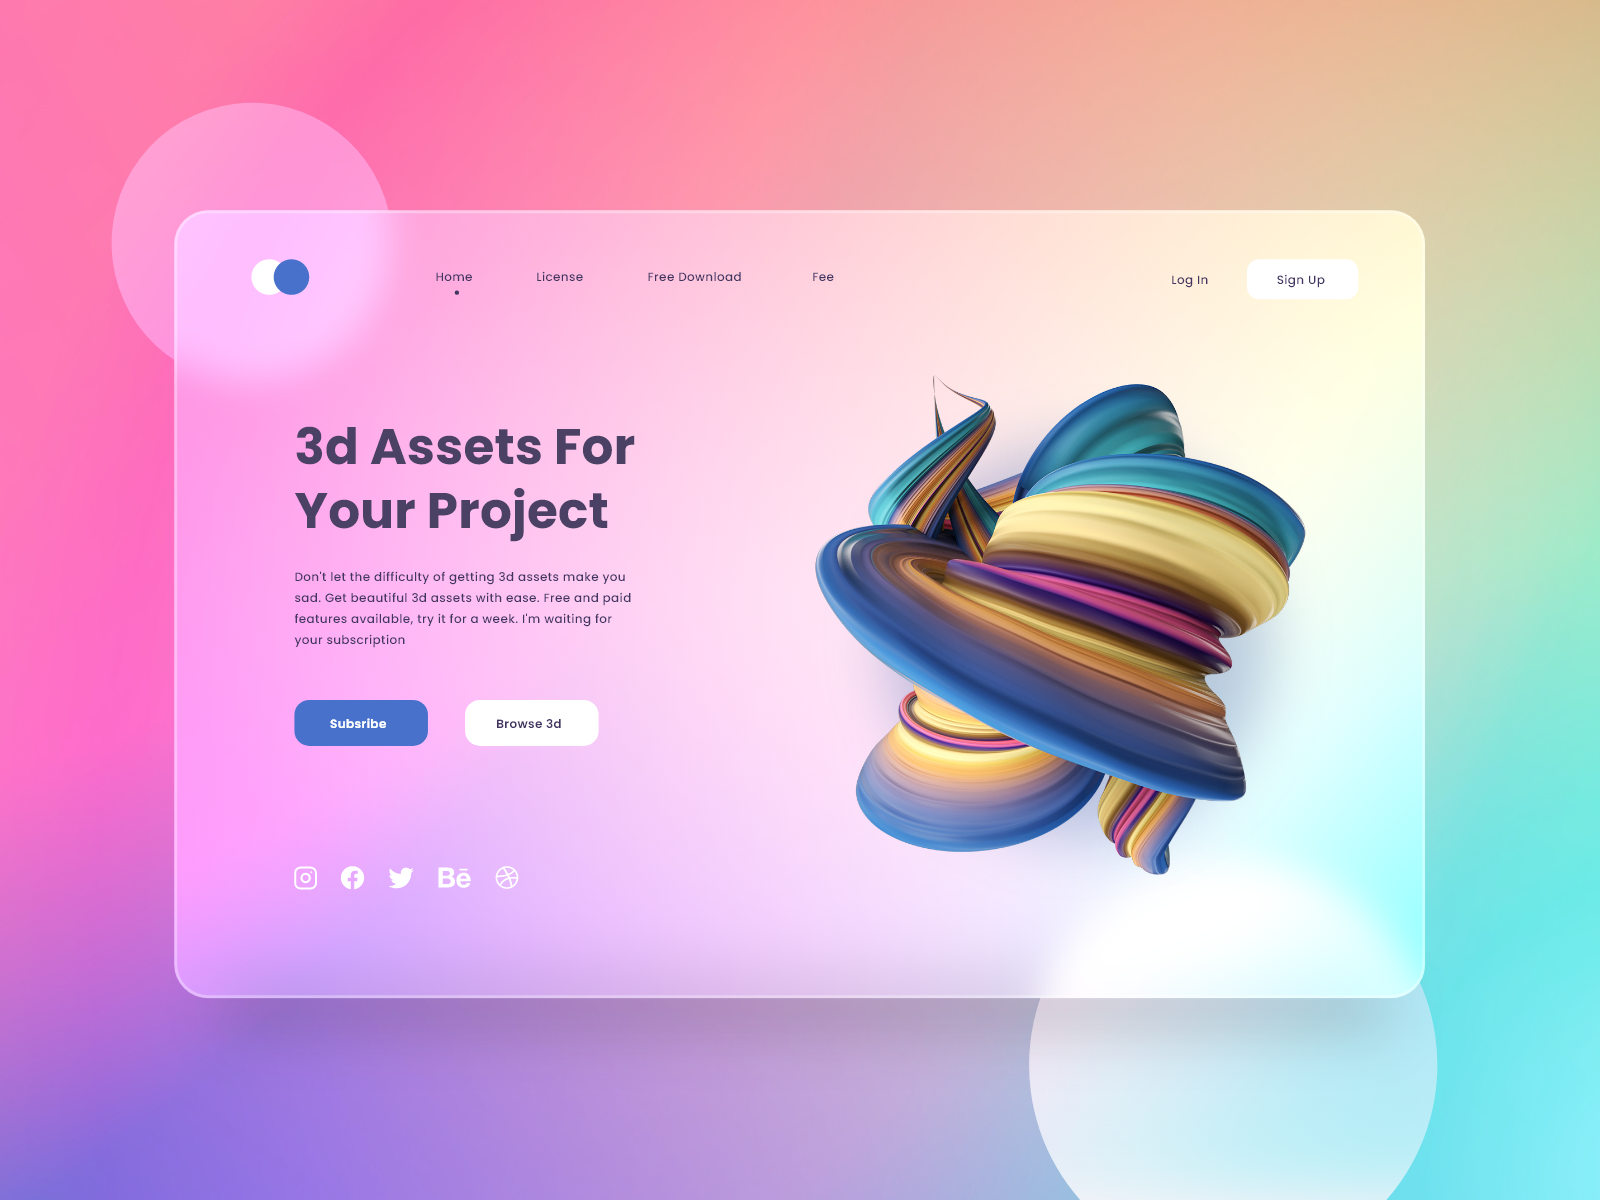

In [ ]:
image

In [ ]:
%%time
result = ask_image(image, "", "Describe this image")
print(textwrap.fill(result, width=110))

The image is a computer screen displaying a website with a colorful spiral design. The spiral is made up of
different colors, including pink, purple, and blue. The website is promoting 3D assets for your project, with
a call to action to download the assets. The website is visually appealing and showcases the creativity and
design skills of the creators.
CPU times: user 13.6 s, sys: 578 ms, total: 14.1 s
Wall time: 21.2 s


In [ ]:
%%time
print(textwrap.fill(result, width=110))

I'm sorry, I am a text-based AI and do not have the ability to display images. Is there anything else I can
help you with?
CPU times: user 5.5 s, sys: 191 ms, total: 5.69 s
Wall time: 6.22 s


In [ ]:
%%time
print(textwrap.fill(result, width=100))

The image depicts a user interface from a web application or software system, featuring a variety of
elements designed for user interaction and data presentation.  1. **Button**: A prominent button is
located in the upper left corner of the image. It has a red background and white text, which stands
out against the rest of the interface. The button's size is relatively large, and its position is in
the upper left quadrant of the screen.  2. **Text Field**: A text field is situated in the middle-
left section of the image. It has a white background and black text, which creates a clear contrast
against the background. The text field's size is moderate, and its position is in the middle-left
quadrant of the screen.  3. **Dropdown Menu**: A dropdown menu is located in the middle-right
section of the image. It has a white background and black text, which also contrasts well with the
background. The dropdown menu's size is moderate, and its position is in the middle-right quadrant
of the sc

In [ ]:
%%time
result_ = ask_image(image,system_prompt ,"")
print(textwrap.fill(result, width=100))

In the image, there is a user interface displaying a list of options, with each option represented
by a colored box. The boxes are arranged in a row, with each box having a different color. The
colors are red, green, yellow, and blue. The boxes are labeled with the names of the options, which
are displayed in a foreign language.  The interface appears to be designed for easy navigation and
user interaction. The colored boxes are visually distinct, making it simple for users to identify
and select the desired option. The labels provide clear information about the options, ensuring that
users can quickly understand the choices available to them.  The overall aesthetics of the interface
are clean and organized, with a focus on functionality and ease of use. The choice of colors and the
arrangement of the boxes contribute to the user-friendly design, making it an efficient and user-
centric interface.
CPU times: user 19.2 s, sys: 933 ms, total: 20.1 s
Wall time: 20.2 s


In [ ]:
%%time
result2 = ask_image(image2,"" ,system_prompt)
print(textwrap.fill(result2, width=100))

The image depicts a user interface from a web application or software system, featuring a variety of
elements designed for user interaction and data presentation.  1. **Button**: A prominent button is
located in the upper-left corner of the image. It has a white background with a blue outline and is
labeled "Mobile Urban." The button's size and position make it easily noticeable and accessible to
the user.  2. **Text Field**: A text field is situated in the middle-left section of the image. It
is labeled "Equilibre" and is accompanied by a dropdown menu. The text field's size and positioning
allow for easy input and selection of options.  3. **Dropdown Menu**: A dropdown menu is located
next to the text field. It is labeled "Equilibre" and contains several options, including "Fort" and
"Fable." The menu's size and positioning are appropriate for easy access and visibility.  4.
**Icons**: There are two icons in the image, one in the upper-right corner and the other in the
lower-right co

In [ ]:
system_prompt="""
Your task is to conduct a comprehensive analysis of a set of images pertaining to a user interface from a web application or software system. Each image demonstrates different aspects of this interface, specifically designed for categorization or evaluation of locations or items.

Instructions:

 Descriptive Analysis:
- For each image, meticulously describe every visible element. Mention:
  - The nature of the element (button, icon, text, etc.).
  - Its shape, color, size, position on the image, and orientation.
  - Any relevant visual details that can be detected, including possible interactions indicated by the interface.

 Comparative Analysis:
- After detailing each image individually, proceed with a comparison to:
  - Identify and explain differences in design, layout, functionalities, and interactivity between the images.
  - Highlight how these variations influence user experience and efficiency in performing tasks within the application.


"""

In [ ]:
%%time
print(textwrap.fill(result3, width=100))

1. Image 1: - The image features a user interface with a prominent search bar at the top. - There
are two buttons, one on the left side and another on the right side of the search bar. - The left
button is larger and positioned higher, while the right button is smaller and positioned lower. -
The interface also includes a text input field below the search bar, which is likely used for
entering search queries. - The overall layout of the interface appears to be simple and
straightforward, with a focus on the search functionality. 2. Image 2: - The image displays a more
complex user interface with multiple buttons and icons. - There are three buttons, one on the left
side, another in the middle, and the third on the right side of the interface. - Additionally, there
are three icons, one on the left side, another in the middle, and the third on the right side. - The
layout of the interface seems to be more intricate, with various options and functionalities
available to the user. - The pr

In [ ]:
print(textwrap.fill(final_result, width=100))

 First images analysis : /n The image depicts a user interface from a web application or software
system, featuring a variety of elements designed for user interaction and data presentation.  1.
**Button**: A prominent button is located in the upper left corner of the image. It has a red
background and white text, which stands out against the rest of the interface. The button's size is
relatively large, and its position is in the upper left quadrant of the screen.  2. **Text Field**:
A text field is situated in the middle-left section of the image. It has a white background and
black text, which creates a clear contrast against the background. The text field's size is
moderate, and its position is in the middle-left quadrant of the screen.  3. **Dropdown Menu**: A
dropdown menu is located in the middle-right section of the image. It has a white background and
black text, which also contrasts well with the background. The dropdown menu's size is moderate, and
its position is in the midd

In [ ]:
%%time
print(textwrap.fill(result, width=100))

Key Elements:  1. Buttons: There are four buttons in the image, each with different functions. 2.
Text Fields: There are two text fields, one for entering information and another for displaying
information. 3. Icons: There are two icons, one for navigation and another for a specific action. 4.
Dropdown Menus: There are two dropdown menus, one for selecting an option and another for displaying
information.  Interactions:  1. Navigation Button: When clicked, the navigation button takes the
user to a new page or screen. 2. Information Entry Field: When the user types information into the
field, it is saved and displayed on the screen. 3. Information Display Field: When the user clicks
on the field, the displayed information is updated. 4. Action Button: When clicked, the action
button performs a specific task related to the application. 5. Dropdown Menu: When the user clicks
on the dropdown menu, a list of options is displayed, and the user can select one of them.  Textual
Content:  The b

In [ ]:
%%time
result_ = ask_image(image,system_prompt ,"")
print(textwrap.fill(result, width=100))

In the image, there is a user interface displaying a list of options, with each option represented
by a colored box. The boxes are arranged in a row, with each box having a different color. The
colors are red, green, yellow, and blue. The boxes are labeled with the names of the options, which
are displayed in a foreign language.  The interface appears to be designed for easy navigation and
user interaction. The colored boxes are visually distinct, making it simple for users to identify
and select the desired option. The labels provide clear information about the options, ensuring that
users can quickly understand the choices available to them.  The overall aesthetics of the interface
are clean and organized, with a focus on functionality and ease of use. The choice of colors and the
arrangement of the boxes contribute to the user-friendly design, making it an efficient and user-
centric interface.
CPU times: user 19.2 s, sys: 933 ms, total: 20.1 s
Wall time: 20.2 s


In [ ]:
%%time
result2 = ask_image(image2,"" ,system_prompt)
print(textwrap.fill(result2, width=100))

Key Elements:  1. Buttons: These are used to initiate actions or navigate within the application. 2.
Text Fields: These are used to input information, such as text or numbers. 3. Icons: These are used
to represent functions or actions within the application. 4. Dropdown Menus: These are used to
display a list of options or choices for the user to select.  Interactions:  1. Buttons: When
clicked, they perform specific actions, such as submitting information, navigating to a new page, or
opening a new window. 2. Text Fields: When filled in, they allow the user to input information,
which is then used by the application to perform specific tasks. 3. Icons: When clicked, they
initiate a specific action or function within the application. 4. Dropdown Menus: When selected,
they display a list of options for the user to choose from, which then affects the application's
behavior.  Highlight Textual Content:  The image shows a user interface with text in French. The
text is used to provide guid

In [ ]:
system_prompt="""
Task: Conduct a comparative analysis of several user interface images from various web applications or software systems. Focus on key functionalities, user interactions, and differences in usability.

Instructions:

Element Comparison: For each image, identify the main elements (e.g., buttons, text fields, icons, dropdown menus) and their primary functions. Highlight differences in how similar functions are implemented across interfaces.

Interaction Analysis: Describe the expected user interaction for each main element across images (e.g., navigation, submitting information). Note any unique or innovative interaction patterns.

Textual Content Overview: Examine critical textual content on elements like buttons or menus, noting how wording choices might influence user comprehension and action. Compare the clarity and effectiveness of these textual cues across interfaces.

Layout and Usability Comparison: Provide an overview of the arrangement of elements in each interface and discuss their effectiveness in facilitating user navigation and task completion. Identify which designs appear more user-friendly and why.

Concluding Observations: Summarize key findings regarding how each interface supports or hinders user tasks and overall experience. Highlight standout features or areas for improvement based on the comparison.

Objective: The goal is to uncover functional design differences, user interaction variances, and usability insights across multiple interfaces, with an emphasis on comparative analysis to deduce best practices and design strategies.

"""

In [ ]:
%%time
print(textwrap.fill(result3, width=100))

Element Comparison:  1. The images showcase various user interface elements, such as buttons, text
fields, and dropdown menus. Some interfaces have a more prominent and visually striking design,
while others have a more minimalist approach. 2. The main elements in the images include buttons,
text fields, and dropdown menus. The buttons are often used for navigation or initiating actions,
while text fields are used for inputting information. Dropdown menus are used to present a list of
options or choices.  Interaction Analysis:  1. The user interactions across the interfaces are
generally consistent, with buttons being used for navigation or initiating actions, text fields for
inputting information, and dropdown menus for presenting options. 2. However, some interfaces may
have unique or innovative interaction patterns, such as the use of gestures or animations to enhance
user experience.  Textual Content Overview:  1. The textual content on elements like buttons or
menus varies across 

In [ ]:
print(textwrap.fill(final_result, width=100))

 First images analysis : /n Key Elements:  1. Buttons: There are four buttons in the image, each
with different functions. 2. Text Fields: There are two text fields, one for entering information
and another for displaying information. 3. Icons: There are two icons, one for navigation and
another for a specific action. 4. Dropdown Menus: There are two dropdown menus, one for selecting an
option and another for displaying information.  Interactions:  1. Navigation Button: When clicked,
the navigation button takes the user to a new page or screen. 2. Information Entry Field: When the
user types information into the field, it is saved and displayed on the screen. 3. Information
Display Field: When the user clicks on the field, the displayed information is updated. 4. Action
Button: When clicked, the action button performs a specific task related to the application. 5.
Dropdown Menu: When the user clicks on the dropdown menu, a list of options is displayed, and the
user can select one of th

# Multi modal

Ce notebook a été nettoyé pour ne conserver que la dernière version de chaque bloc de code utile. Les anciennes versions et les redondances ont été supprimées pour plus de clarté et d'efficacité.

## 1. Segmentation d'image avec SAM

On commence par la segmentation d'image à l'aide du modèle SAM, puis on utilise LLAVA pour l'analyse multimodale des composants segmentés.

---


## Charger et utiliser SAM pour la segmentation d'image

In [ ]:
from transformers import pipeline
from PIL import Image
import numpy as np
import os
import torch  # Pour la gestion de la mémoire GPU

# 1. Charger et utiliser SAM pour la segmentation d'image
generator = pipeline("mask-generation", device=0, points_per_batch=256)
img_url = "/content/Holoffice Download 2024-03-27 14-38-53.png"
raw_image = Image.open(img_url).convert("RGB")
image_np = np.array(raw_image)
outputs = generator(img_url, points_per_batch=256)

# Fonction pour sauvegarder les masques et images segmentées
def save_mask_and_segmented_image(image_np, mask, index, masks_folder='masks_images', random_color=False):
    if not os.path.exists(masks_folder):
        os.makedirs(masks_folder)

    # Calculer la bounding box du masque
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]

    # Recadrer le masque selon la bounding box
    mask_cropped = mask[y_min:y_max+1, x_min:x_max+1]

    # Appliquer le masque recadré à l'image originale pour obtenir l'image segmentée recadrée
    segmented_cropped = image_np[y_min:y_max+1, x_min:x_max+1] * mask_cropped[..., np.newaxis]

    # Enregistrer l'image segmentée recadrée
    segmented_image_path = os.path.join(masks_folder, f'segmented_{index}.png')
    Image.fromarray(segmented_cropped).save(segmented_image_path)


for i, mask in enumerate(outputs["masks"]):
    save_mask_and_segmented_image(image_np, mask, i)



### Après la segmentation, libérer explicitement la mémoire du GPU

In [ ]:
import torch

del generator,img_url,raw_image,image_np,outputs

torch.cuda.empty_cache()

## Charger LLAVA pour l'analyse multimodale

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.1 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off
!pip install -qqq llava-torch==1.1.1 --progress-bar off

In [ ]:
import textwrap
from io import BytesIO

import requests
import torch
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from PIL import Image

In [ ]:
disable_torch_init()
MODEL = "4bit/llava-v1.5-13b-3GB"
model_name = get_model_name_from_path(MODEL)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=MODEL, model_base=None, model_name=model_name, load_4bit=True
)

In [ ]:
CONV_MODE = "llava_v0"
def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

def process_image(image):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

def create_prompt(new_system: str = None, prompt: str = "",   CONV_MODE: str = "default"):
    conv = conv_templates[CONV_MODE].copy()
    if new_system is not None:
        conv.system = new_system
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN+ "\n" + prompt
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

def ask_image(image: Image, pre_prompt: str, prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt( pre_prompt,prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=2048,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()

def ask_text(prompt: str):
    prompt, conv = create_prompt( "",prompt)

    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=1024,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )

    return tokenizer.decode(
        output_ids[0, input_ids.shape[-1]:], skip_special_tokens=True
    ).strip()

def concat_images_with_border(image_1, image_2, border_width=50):

    image1 = load_image(image_1)
    image2 = load_image(image_2)

    width1, height1 = image1.size
    width2, height2 = image2.size
    new_width = max(width1, width2) + border_width * 2
    new_height = height1 + height2 + border_width * 3

    new_image = Image.new('RGB', (new_width, new_height), "black")

    new_image.paste(image1, (border_width, border_width))
    new_image.paste(image2, (border_width, height1 + border_width * 2))

    return new_image



In [ ]:
segmented_images_dir = 'masks_images'
segmented_images = [os.path.join(segmented_images_dir, f) for f in os.listdir(segmented_images_dir) if f.endswith('.png')]

descriptions = []
for image_path in segmented_images:
    image = Image.open(image_path).convert("RGB")
    description = ask_image(image, "", "Describe this component")
    descriptions.append(description)

In [ ]:
print(textwrap.fill(descriptions, width=110))